In [1]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
import os
from PIL import Image

import sys
sys.path.append('cloth3d')
sys.path.append('cloth3d/DataReader')
sys.path.append('cloth3d/DataReader/smpl')

from cloth3d.DataReader.read import DataReader
from cloth3d.DataReader.depth_render import Render
from cloth3d.DataReader.util import intrinsic, extrinsic

# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

N_TRAIN = 128
N_VAL = 16

n_epochs = 20
batch_size = 4


SRC: cloth3d++_subset/


In [2]:
class TFRecordDataHandler:
    def __init__(self, tfrecord_file, batch_size=32, shuffle=True, augment=False):
        self.tfrecord_file = tfrecord_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

    def _parse_function(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'depth': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth_height': tf.io.FixedLenFeature([], tf.int64),
            'depth_width': tf.io.FixedLenFeature([], tf.int64)
        }
        parsed_features = tf.io.parse_single_example(proto, feature_description)
        
        image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
        depth = tf.io.decode_raw(parsed_features['depth'], tf.float32)
        
        height = parsed_features['height']
        width = parsed_features['width']
        
        image = tf.reshape(image, [height, width, 3])
        depth = tf.reshape(depth, [parsed_features['depth_height'], parsed_features['depth_width']])
        
        return image, depth

    def _normalize(self, image, depth):
        # Convert image to float for processing and normalize to range [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        # Create a mask where depth values are greater than zero
        depth_mask = depth > 0

        # Normalize depth based on masked regions
        # Calculate the mean of the depth where it is greater than zero
        depth_values = tf.boolean_mask(depth, depth_mask)
        depth_mean = tf.reduce_mean(depth_values)

        # Subtract the mean from the depth values where mask is true
        depth = tf.where(depth_mask, depth - depth_mean, depth)

        # Set depth values less than 0 to 0 after subtraction
        depth = tf.maximum(depth, 0)

        # Prepare the mask for RGB image normalization
        mask = tf.tile(tf.expand_dims(depth_mask, axis=-1), [1, 1, 3])

        # Masked image for mean and std deviation calculation
        masked_image = tf.boolean_mask(image, mask)
        mean, variance = tf.nn.moments(masked_image, axes=[0])
        std_dev = tf.sqrt(variance + 1e-6)  # Adding epsilon to avoid division by zero

        # Apply the mask to image normalization
        normalized_image = tf.where(
            mask,
            (image - mean) / std_dev,
            image  # Preserve original pixels where mask is False
        )

        return normalized_image, depth

    def _augment(self, image, depth):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            depth = tf.image.flip_left_right(tf.expand_dims(depth, axis=-1))
            depth = tf.squeeze(depth, axis=-1)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, depth

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self._normalize, num_parallel_calls=tf.data.AUTOTUNE)

        if self.augment:
            dataset = dataset.map(self._augment, num_parallel_calls=tf.data.AUTOTUNE)

        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset


In [3]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr):.6f}")

class TensorBoardLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir='./logs'):
        super(TensorBoardLearningRateLogger, self).__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        with self.file_writer.as_default():
            tf.summary.scalar('learning_rate', tf.keras.backend.get_value(lr), step=epoch)

In [4]:
def visualize_hist(history, show=True, filename=None, title='Training history'):
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()

    if filename is not None:
        fig.savefig(filename)

(5, 256, 256, 3) (5, 256, 256)


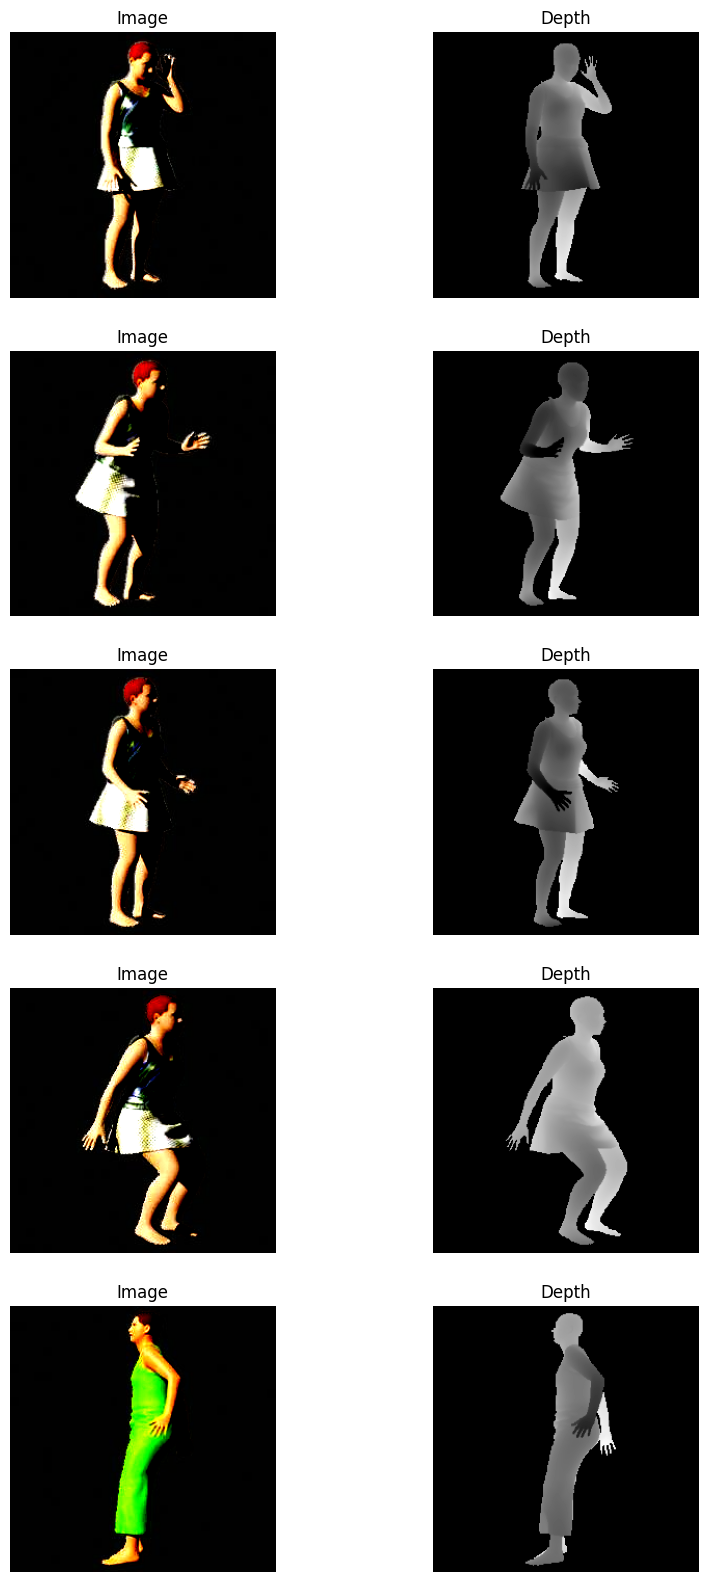

In [5]:
import matplotlib.pyplot as plt

def visualize_data(images, depths, num_samples=5):
    plt.figure(figsize=(10, num_samples * 4))  # Adjusted for better visualization layout
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        # Clip the image data to ensure it's within the valid range
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2 * i + 2)
        # For depth, ensure it is normalized or adjust accordingly
        plt.imshow(depths[i], cmap='gray')
        plt.title("Depth")
        plt.axis('off')
    plt.show()


# Carga algunos datos de ambos métodos
handler = TFRecordDataHandler('train.tfrecords', batch_size=5, shuffle=False, augment=False)
dataset = handler.load_dataset()
images_tf, depths_tf = next(iter(dataset))

print(images_tf.shape, depths_tf.shape)
# Visualiza los datos de ambos métodos
visualize_data(images_tf, depths_tf, num_samples=5)


# Experiment 1: Constant Learning Rates

Number of data used to train:
Train: 372

Learning rate: 1e-05
Epoch 1/20
93/93 [==============================] - 29s 280ms/step - loss: 0.1863 - mae: 0.3900 - val_loss: 0.1349 - val_mae: 0.3551
Epoch 2/20
93/93 [==============================] - 26s 273ms/step - loss: 0.1242 - mae: 0.3006 - val_loss: 0.0801 - val_mae: 0.2735
Epoch 3/20
93/93 [==============================] - 26s 275ms/step - loss: 0.0882 - mae: 0.2558 - val_loss: 0.0583 - val_mae: 0.2307
Epoch 4/20
93/93 [==============================] - 26s 276ms/step - loss: 0.0656 - mae: 0.2220 - val_loss: 0.0466 - val_mae: 0.2030
Epoch 5/20
93/93 [==============================] - 26s 276ms/step - loss: 0.0512 - mae: 0.1983 - val_loss: 0.0391 - val_mae: 0.1854
Epoch 6/20
93/93 [==============================] - 26s 275ms/step - loss: 0.0421 - mae: 0.1816 - val_loss: 0.0345 - val_mae: 0.1756
Epoch 7/20
93/93 [==============================] - 26s 273ms/step - loss: 0.0371 - mae: 0.1722 - val_loss: 0.0328 - val_mae: 0.1702
Epoch 

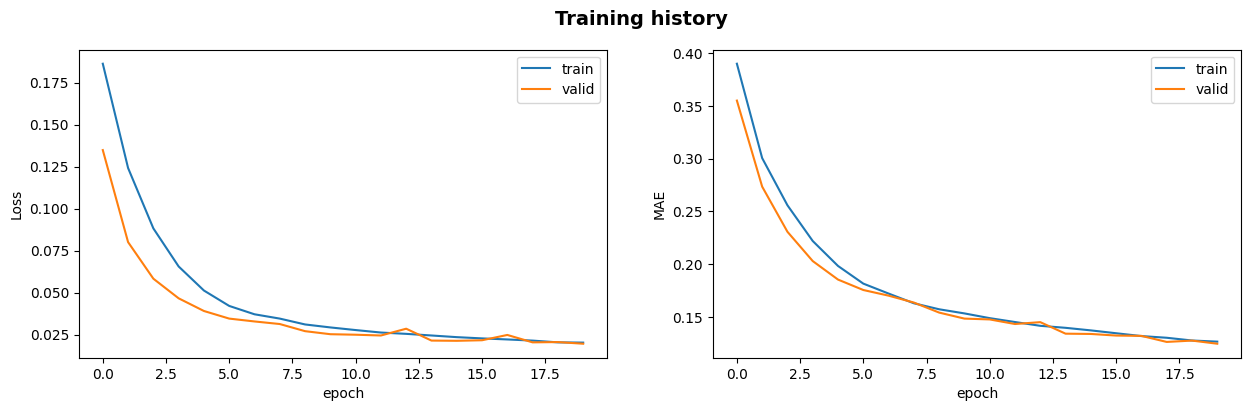

Best validation loss: 0.019583646208047867 at epoch 19


In [29]:
# Training
# hyperparameters
checkpoint = './best_model.h5'
shuffle = True
verbose = 1

# creating data generators to load the data
train_dg = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True).load_dataset()
validation_dg = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False).load_dataset()
print('Number of data used to train:')
print('Train:', len(list(train_dg) * batch_size))
print('')

d_lr = {}
for lr in [1e-05]:

    # Create model
    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                        stack_num_down=2, stack_num_up=1,
                        activation='GELU', output_activation='Sigmoid', 
                        batch_norm=True, pool='max', unpool=False, name='unet')

    print('Learning rate:', lr)

    experiment_name = 'lr_'+str(lr)

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(log_dir=os.path.join('./logs', experiment_name))
    
    # defining the optimizer
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, 
                        callbacks=[tensorboard_callback])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history_lr_'+str(lr)+'.png')
    visualize_hist(history, show=True, filename=filename)
    
    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 2: Warmup Learning Rates

In [6]:
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)
        
        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)
        
        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate
        
        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }


: 

Number of data used to train:
372

Learning rate: 1e-05
Epoch 1/20
93/93 [==============================] - 28s 273ms/step - loss: 0.0476 - mae: 0.1465 - val_loss: 0.9080 - val_mae: 0.9399
Epoch 2/20
93/93 [==============================] - 25s 271ms/step - loss: 0.0099 - mae: 0.0547 - val_loss: 0.0264 - val_mae: 0.0580
Epoch 3/20
93/93 [==============================] - 26s 274ms/step - loss: 0.0070 - mae: 0.0356 - val_loss: 0.0104 - val_mae: 0.0428
Epoch 4/20
93/93 [==============================] - 26s 273ms/step - loss: 0.0064 - mae: 0.0323 - val_loss: 0.0097 - val_mae: 0.0424
Epoch 5/20
93/93 [==============================] - 26s 273ms/step - loss: 0.0061 - mae: 0.0307 - val_loss: 0.0081 - val_mae: 0.0341
Epoch 6/20
93/93 [==============================] - 26s 273ms/step - loss: 0.0058 - mae: 0.0298 - val_loss: 0.0085 - val_mae: 0.0350
Epoch 7/20
93/93 [==============================] - 26s 273ms/step - loss: 0.0056 - mae: 0.0285 - val_loss: 0.0111 - val_mae: 0.0389
Epoch 8/20
93

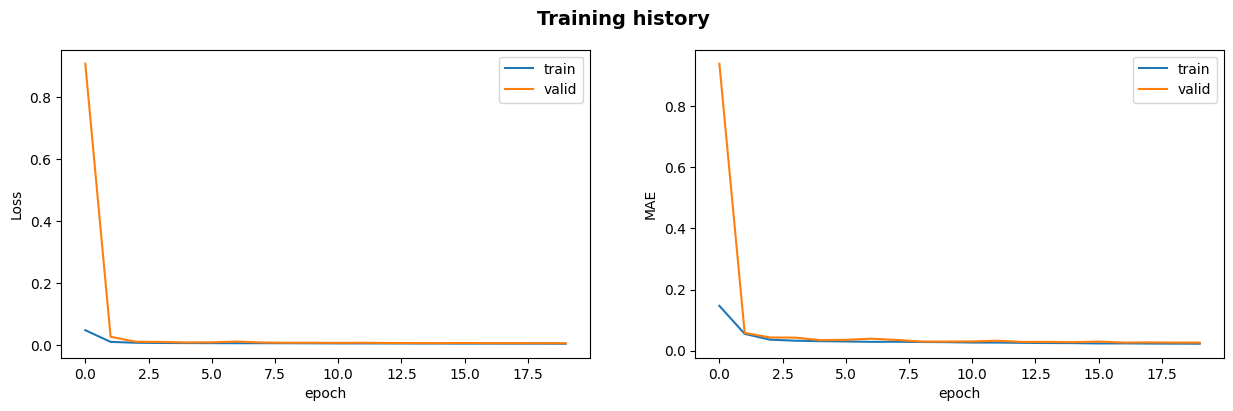

Best validation loss: 0.005693765357136726 at epoch 19


In [28]:
# Parameters
initial_learning_rate = 1e-5
target_learning_rate = 1e-2
verbose = 1
shuffle = True
checkpoint = './best_model.h5'

# Training
train_dg = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True).load_dataset()
validation_dg = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False).load_dataset()
print('Number of data used to train:')
print(len(list(train_dg))* batch_size)
print('')

total_steps = len(list(train_dg)) * n_epochs


for wu_ratio in [0.1]:

    warmup_steps = int(wu_ratio * total_steps)

    experiment_name = f'lr_decay_{initial_learning_rate}_{target_learning_rate}_wu_ratio_{wu_ratio}'

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join('./logs', experiment_name))

    # Create the learning rate schedule
    lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                        stack_num_down=2, stack_num_up=1,
                        activation='GELU', output_activation='Sigmoid', 
                        batch_norm=True, pool='max', unpool=False, name='unet')

    print('Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, 
                        callbacks=[tensorboard_callback])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 3: Learning Rate Schedules (No Warmup)

In [30]:
# Parameters
initial_learning_rate = 1e-8
target_learning_rate = 1e-5
verbose = 1
shuffle = True
checkpoint = './best_model.h5'



# Training
train_dg = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True).load_dataset()
validation_dg = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False).load_dataset()
print('Number of data used to train:')
print(len(list(train_dg))* batch_size)
print('')
total_steps = len(list(train_dg)) * n_epochs


for initial_lr in [1e-6]:

    initial_learning_rate = initial_lr

    experiment_name = f'lr_decay_{initial_learning_rate}'

    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(os.path.join('./logs', experiment_name))

    # TensorBoard learning rate logger callback
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join('./logs', experiment_name))

    lr_schedule = keras.optimizers.schedules.CosineDecay(
                    initial_learning_rate,
                    total_steps,
                    alpha=1e-3,
                    name="CosineDecay",
                )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                            stack_num_down=2, stack_num_up=1,
                            activation='GELU', output_activation='Sigmoid', 
                            batch_norm=True, pool='max', unpool=False, name='unet')

    print('Initial Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=4, callbacks=[tensorboard_callback, tensorboard_lr_logger])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of data used to train:
372

Initial Learning rate: 1e-06
Epoch 1/20
      6/Unknown - 4s 238ms/step - loss: 0.2724 - mae: 0.5020WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1117s vs `on_train_batch_end` time: 0.1276s). Check your callbacks.
93/93 [==============================] - 28s 274ms/step - loss: 0.2658 - mae: 0.4976 - val_loss: 0.2283 - val_mae: 0.4612
Epoch 2/20
93/93 [==============================] - 25s 272ms/step - loss: 0.2444 - mae: 0.4775 - val_loss: 0.2112 - val_mae: 0.4442
Epoch 3/20
93/93 [==============================] - 26s 274ms/step - loss: 0.2269 - mae: 0.4579 - val_loss: 0.1883 - val_mae: 0.4200
Epoch 4/20
93/93 [==============================] - 26s 274ms/step - loss: 0.2120 - mae: 0.4388 - val_loss: 0.1756 - val_mae: 0.4045
Epoch 5/20
93/93 [==============================] - 26s 273ms/step - loss: 0.1985 - mae: 0.4210 - val_loss: 0.1743 - val_mae: 0.3989
Epoch 6/20
37/93 [==========>........

KeyboardInterrupt: 